In [2]:
from db_utils import *
from acf_utils import *

/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorf

In [2]:
paths = ['lorenz_wgangp/runs/7/gen_trajs.npy']
gen = np.load(paths[0])

M=np.max(gen)
m=np.min(gen)
gen = (gen-m)/(M-m)
# riscalo le traiettorie generate come le avevo riscalate
# per le traiettorie input della rete predictor
M = 31.27666666957781 
m = -31.28223237314301
gen = gen*(M-m) + m
M = 33.45311378674468
m = -33.45763272036239
gen = (gen-m)/(M-m)
db = load_data_predictor([54.])

(50000, 2000, 1)
33.45311378674468 -33.45763272036239
0.9674723832749993 0.03251197245256134


# Predictor

W0523 10:36:55.235300 47154876464640 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0523 10:36:55.236989 47154876464640 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0523 10:36:55.306633 47154876464640 deprecation.py:506] From /usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__i

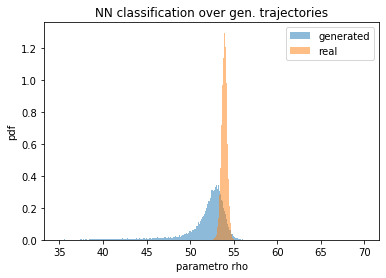

In [3]:
predictor = load_model('models/predictor_10_20_30_40_50_60.h5')
lM = 60.
lm = 10.
def norm_labels(labels):
    return (labels - lm)/(lM - lm)
def denorm_labels(labels):
    return labels * (lM - lm) + lm

previsione = denorm_labels(predictor.predict(gen))
plt.hist(previsione, bins=np.arange(35,70,0.05), density=True, alpha=0.5, label='generated')
previsione = denorm_labels(predictor.predict(db))
plt.hist(previsione, bins=np.arange(35,70,0.05), density=True, alpha=0.5, label='real')

plt.legend()
plt.title('NN classification over gen. trajectories')
plt.xlabel('parametro rho')
plt.ylabel('pdf')
plt.legend()
plt.savefig("plots/gan_test_predictor.png", dpi=100, format='png')
plt.show()

# Exit time

computing exit time for r=54, 49999 Saved!


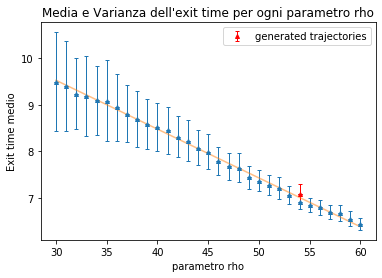

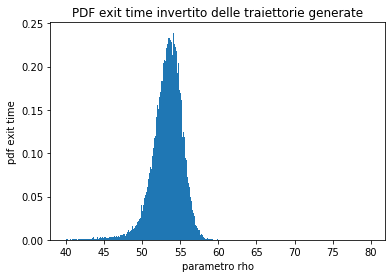

In [4]:
# CALCOLO EXIT TIME SU TRAIETTORIE GENERATE
gen_exit_time(paths,0.5)

# EXIT TIME DELLE TRAIETTORIE REALI
soglia = 0.5
rv = range(30,61,1)
paths_et_real = [f'/scratch/scarpolini/databases/exit_time_{soglia:.2f}_lorenz_{r:.1f}.npy' for r in rv]
paths_et_gen = '/scratch/scarpolini/databases/gen_exit_time_0.50_lorenz_54.0.npy'
et = [np.load(path) for path in paths_et_real]
labels = [str(r) for r in rv]
means = [np.mean(x) for x in [x[0] for x in et]]
stds = [np.std(x) for x in [x[0] for x in et]]

# FIT
from scipy.optimize import curve_fit
def retta(x, a, b):
    return a*x + b
rvv = np.array(range(30,70,10))
a, b = curve_fit(retta, rv, means)
fit = retta(rv, a=a[0], b=a[1])
def inversa(y):
    return (1./a[0])*y - a[1]/a[0]

# GEN TRAJECTORIES
gen_et = np.load(paths_et_gen)
gen_mean, gen_std = np.mean(gen_et), np.std(gen_et)
# PLOTTO REALI
l, caps, c = plt.errorbar(rv, means, stds, lw=0, marker='^', ms=4, elinewidth=1, uplims=True, lolims=True, capsize=2)
for cap in caps:
    cap.set_marker("_")
# PLOTTO GENERATE
l, caps, c = plt.errorbar([54.0], gen_mean, gen_std, lw=0, marker='^', ms=4, color='red', elinewidth=1, uplims=True, lolims=True, capsize=2, label='generated trajectories')
for cap in caps:
    cap.set_marker("_")    

# PLOT ET
plt.plot(rv, fit, alpha = 0.5)
plt.xlabel('parametro rho')
plt.ylabel('Exit time medio')
plt.title("Media e Varianza dell'exit time per ogni parametro rho")
plt.legend()
plt.savefig("plots/gan_test_et.png", dpi=100, format='png')
plt.show()

# PLOT ET PDF
inv_et_gen = inversa(gen_et).reshape(50000)
plt.title('PDF exit time invertito delle traiettorie generate')
plt.hist(inv_et_gen, bins=np.arange(40,80,0.1), density=True)
plt.xlabel('parametro rho')
plt.ylabel('pdf exit time')
plt.savefig("plots/gan_test_et_pdf.png", dpi=100, format='png')
plt.show()

# Gradients

In [5]:
g = np.gradient(db,axis=1)
gg = np.gradient(g,axis=1)
gm = np.gradient(gen,axis=1)
ggm = np.gradient(gm,axis=1)

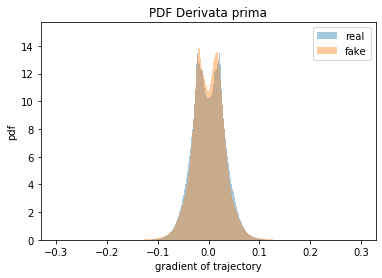

In [6]:
plt.title('PDF Derivata prima')
plt.hist(g.flatten(), bins=np.arange(-0.3,0.3,0.001), label='real', alpha=0.4, density=True)
plt.hist(gm.flatten(), bins=np.arange(-0.3,0.3,0.001), label='fake', alpha=0.4, density=True)
plt.legend()
plt.xlabel('gradient of trajectory')
plt.ylabel('pdf')
plt.savefig('plots/gan_test_d1.png', fmt='png', dpi=100)
plt.show()

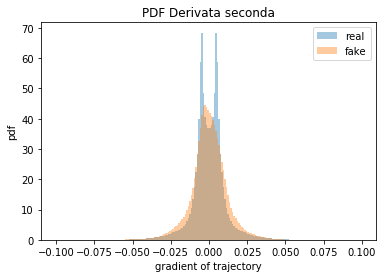

In [7]:
plt.title('PDF Derivata seconda')
plt.hist(gg.flatten(), bins=np.arange(-0.1,0.1,0.001), label='real', alpha=0.4, density=True)
plt.hist(ggm.flatten(), bins=np.arange(-0.1,0.1,0.001), label='fake', alpha=0.4, density=True)
plt.legend()
plt.xlabel('gradient of trajectory')
plt.ylabel('pdf')
plt.savefig('plots/gan_test_d2.png', fmt='png', dpi=100)
plt.show()

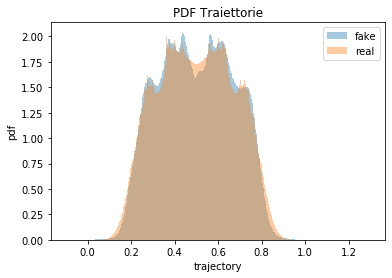

In [8]:
plt.title('PDF Traiettorie')
plt.hist(gen.flatten(), bins=np.arange(-0.1,1.3,0.003), label='fake', alpha=0.4, density=True)
plt.hist(db.flatten(), bins=np.arange(-0.1,1.3,0.003), label='real', alpha=0.4, density=True)
plt.legend()
plt.xlabel('trajectory')
plt.ylabel('pdf')
plt.savefig('plots/gan_test_d0.png', fmt='png', dpi=100)
plt.show()

# Plot Traiettorie Generate e Reali

In [9]:
db = load_data_predictor([54.])
db = db.reshape(50000,2000)

(50000, 2000, 1)
33.45311378674468 -33.45763272036239
0.9674723832749993 0.03251197245256134


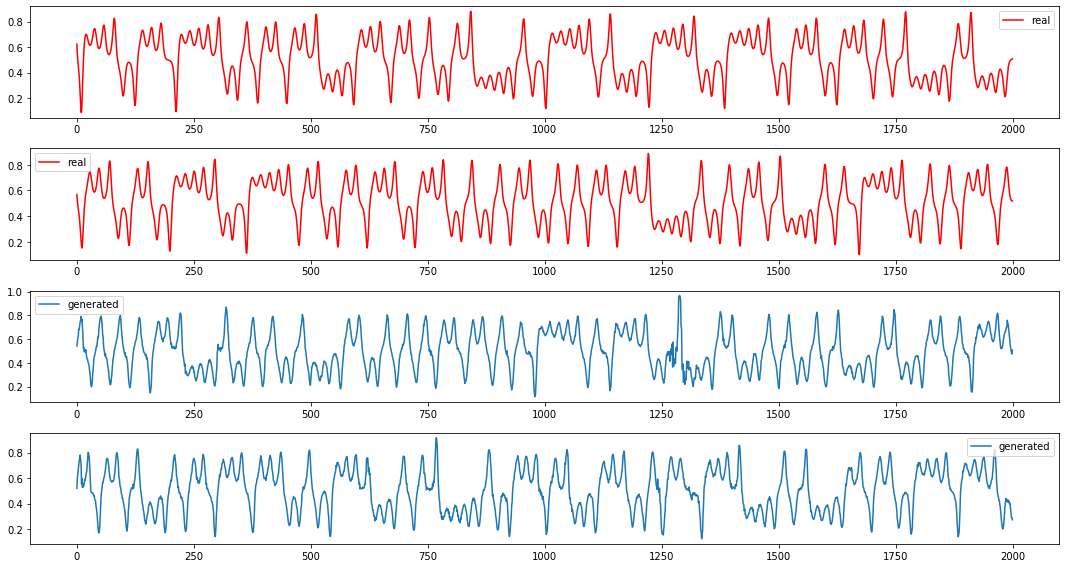

In [10]:
idx1 = np.random.randint(0, db.shape[0], 2)
idx2 = np.random.randint(0, gen.shape[0], 2)
trajs = db[idx1]
gen_trajs = gen[idx2]
plt.figure(figsize=(15, 2*len(trajs)+2*len(gen_trajs)))
plt.title('esempi di traiettorie vere e generate')

for i, traj in enumerate(trajs):
    plt.subplot(len(trajs)+len(gen_trajs), 1, i+1)
    plt.plot(traj, color='red', label='real')
    plt.legend()

for i, traj in enumerate(gen_trajs):
    plt.subplot(len(trajs)+len(gen_trajs), 1, i+1+len(trajs))
    plt.plot(traj, label='generated')
    plt.legend()

plt.tight_layout()
plt.savefig('plots/gan_test_trajs.png', fmt='png', dpi=100)
plt.show()